# Tangle demo on a mixture of gaussians

Simple script for exemplary use of the tangle framework.
The execution is divided in the following steps

    1. Load datasets
    2. Find the cuts and compute the costs
    3. For each cut compute the tangles by expanding on the
          previous ones if it is consistent. If its not possible stop
    4. Postprocess in soft and hard clustering

In [354]:
from functools import partial
from pathlib import Path

import sklearn

from src import cost_functions, data_types, plotting
from src.loading import load_GMM
from src.cut_finding import a_slice
from src import utils

import numpy as np

from src.tree_tangles import ContractedTangleTree, tangle_computation, compute_soft_predictions_children

### Define yout parameters

In [355]:
plot = True
seed = 42
agreement = 20

### Load your data

In [356]:
xs, ys = load_GMM(blob_sizes=[150, 150, 300], blob_centers=[[2, 4], [-2, 0], [0, -4]], blob_variances=[[2, 1], [2, 1], [2, 1]], seed=seed)

data = data_types.Data(xs=xs, ys=ys)

Now we preprocess the data by calculating a set of bipartition.

In [357]:
print("Generating set of bipartitions")
values=a_slice(xs=data.xs, a=agreement)
bipartitions = data_types.Cuts(values)
print("Found {} unique bipartitions".format(len(bipartitions.values)))

Generating set of bipartitions
Found 62 unique bipartitions


Given a cost function we calculate the cost of all bipartitions and sort them accordingly.

In [358]:
print("Calculating costs if bipartitions")
cost_fun = cost_functions.mean_euclidean_distance
bipartitions = utils.compute_cost_and_order_cuts(bipartitions, partial(cost_fun, data.xs, None))

Calculating costs if bipartitions


### Now we can build the tangle search tree.

In [359]:
print("Building the tangle search tree", flush=True)
tangles_tree = tangle_computation(cuts=bipartitions,
                                  agreement=agreement,
                                  verbose=3  # print everything
                                  )

Building the tangle search tree
Using agreement = 20 

Start tangle computation
	Compute tangles of order 2.1975698914587936 with 1 new cuts
		I found 1 tangles of order less or equal 2.1975698914587936
	Compute tangles of order 2.2081822069514416 with 1 new cuts
		I found 2 tangles of order less or equal 2.2081822069514416
	Compute tangles of order 2.220611751989207 with 1 new cuts
		I found 2 tangles of order less or equal 2.220611751989207
	Compute tangles of order 2.325392551702413 with 1 new cuts
		I found 2 tangles of order less or equal 2.325392551702413
	Compute tangles of order 2.3432608533501535 with 1 new cuts
		I found 2 tangles of order less or equal 2.3432608533501535
	Compute tangles of order 2.4555541673762358 with 1 new cuts
		I found 2 tangles of order less or equal 2.4555541673762358
	Compute tangles of order 2.475919734691374 with 1 new cuts
		I found 2 tangles of order less or equal 2.475919734691374
	Compute tangles of order 2.477635641532758 with 1 new cuts
		I f

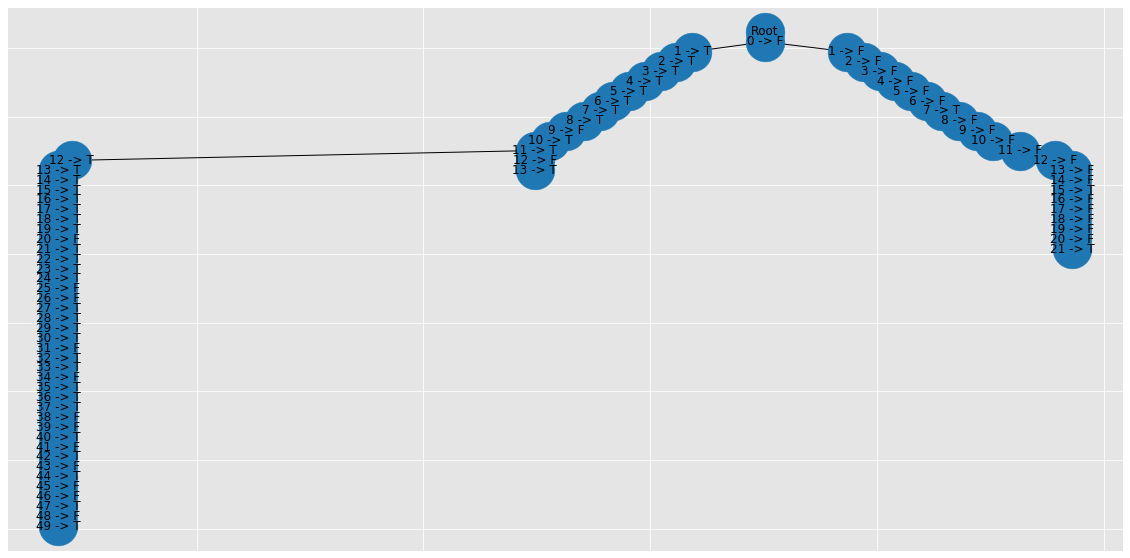

In [360]:
tangles_tree.plot_tree()

We want to posrprocess the tree by contracting paths.

In [361]:
# postprocess tree
print("Postprocessing the tree.", flush=True)
# contract to binary tree
print("Contracting to binary tree", flush=True)
contracted_tree = ContractedTangleTree(tangles_tree)

Postprocessing the tree.
Contracting to binary tree


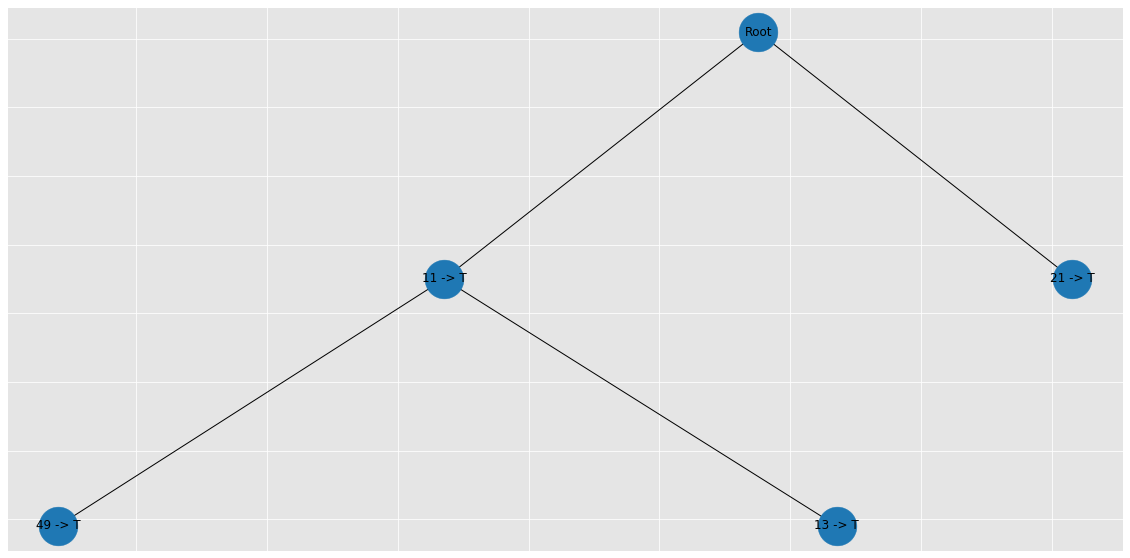

In [362]:
contracted_tree.plot_tree()

In [363]:
# prune short paths
print("Pruning short paths (length at most 1)", flush=True)
contracted_tree.prune(1)

Pruning short paths (length at most 1)
	3 clusters after cutting out short paths.


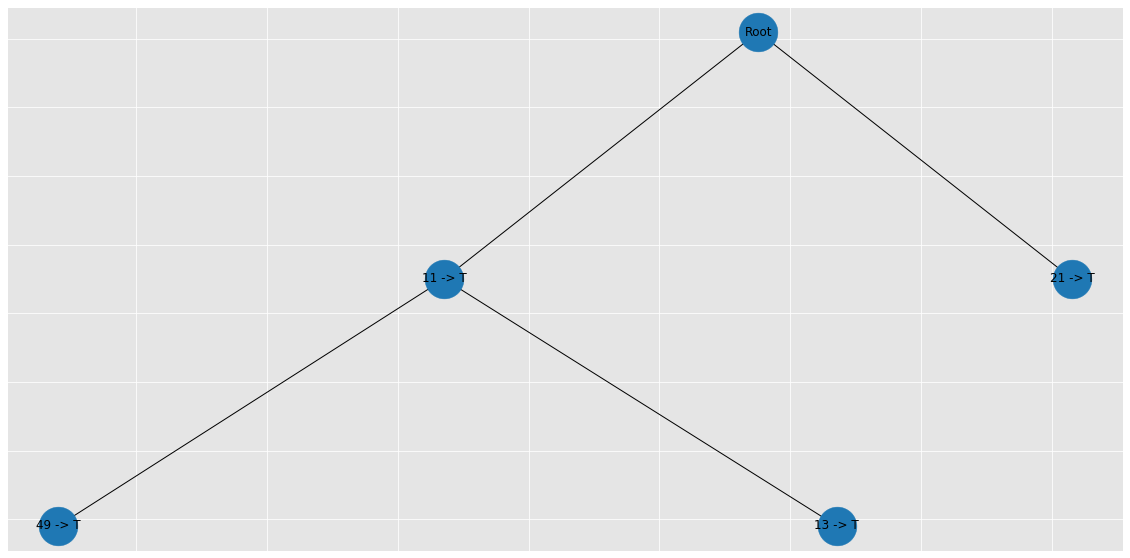

In [364]:
contracted_tree.plot_tree()

In [365]:
# calculate
print("Calculating set of characterizing bipartitions", flush=True)
contracted_tree.calculate_setP()

Calculating set of characterizing bipartitions


In [366]:
# compute soft predictions
# assign weight/ importance to bipartitions
weight = np.exp(-utils.normalize(bipartitions.costs))

# propagate down the tree
print("Calculating soft predictions", flush=True)
compute_soft_predictions_children(node=contracted_tree.root,
                                  cuts=bipartitions,
                                  weight=weight,
                                  verbose=3)

contracted_tree.processed_soft_prediction = True

Calculating soft predictions


In [367]:
print("Calculating hard predictions", flush=True)
ys_predicted, _ = utils.compute_hard_predictions(contracted_tree, cuts=bipartitions)

Calculating hard predictions


In [368]:
# evaluate hard predictions
if data.ys is not None:
    ARS = sklearn.metrics.adjusted_rand_score(data.ys, ys_predicted)
    NMI = sklearn.metrics.normalized_mutual_info_score(data.ys, ys_predicted)

    print('Adjusted Rand Score: {}'.format(np.round(ARS, 4)), flush=True)
    print('Normalized Mutual Information: {}'.format(np.round(NMI, 4)), flush=True)

Adjusted Rand Score: 0.9233
Normalized Mutual Information: 0.8782


In the following we visualize the ouput.

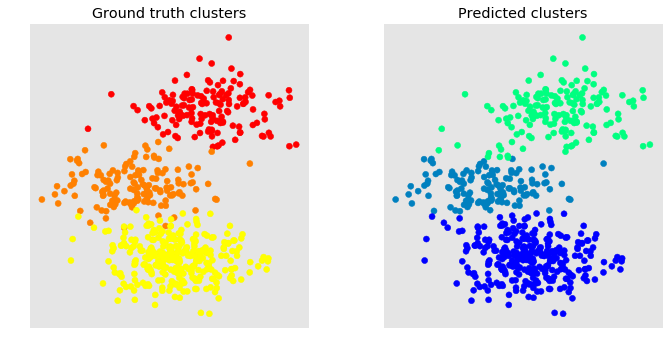

In [369]:
# plot hard clustering
plotting.plot_hard_predictions(data=data, ys_predicted=ys_predicted, path=None)

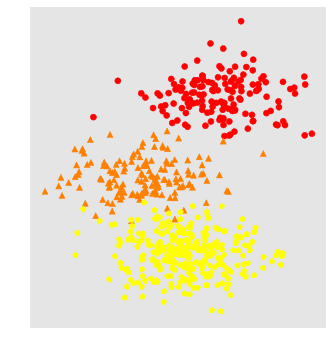

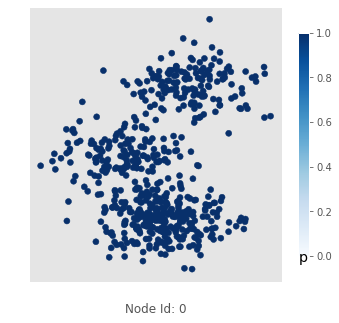

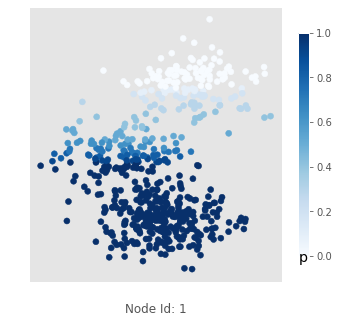

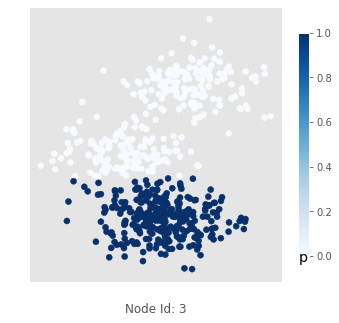

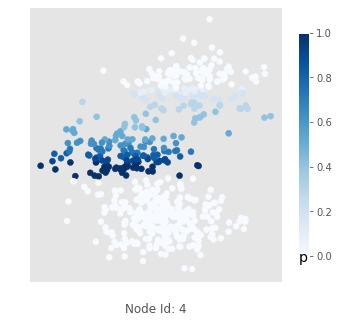

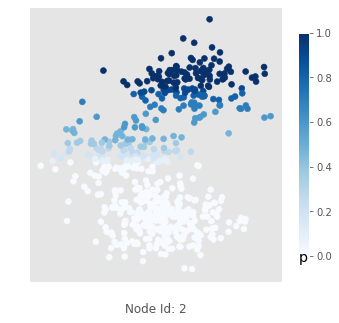

In [370]:
# plot soft predictions
plotting.plot_soft_predictions(data=data,
                                   contracted_tree=contracted_tree,
                                   eq_cuts=bipartitions.equations,
                                   path=None)

We can plot the cheapest cuts.

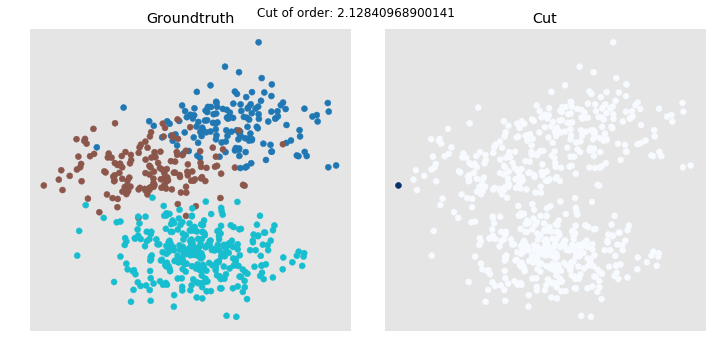

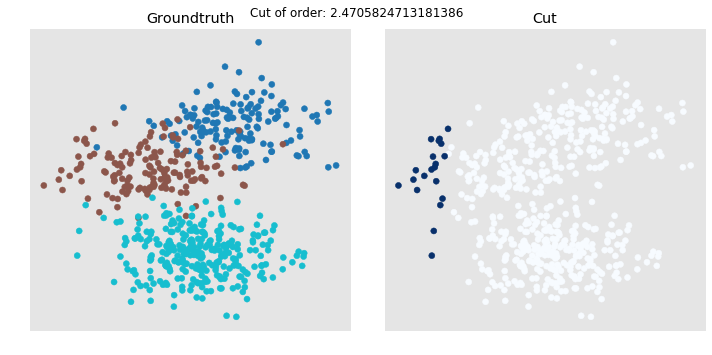

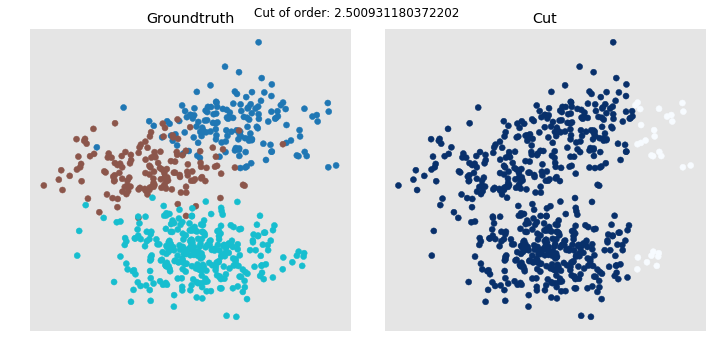

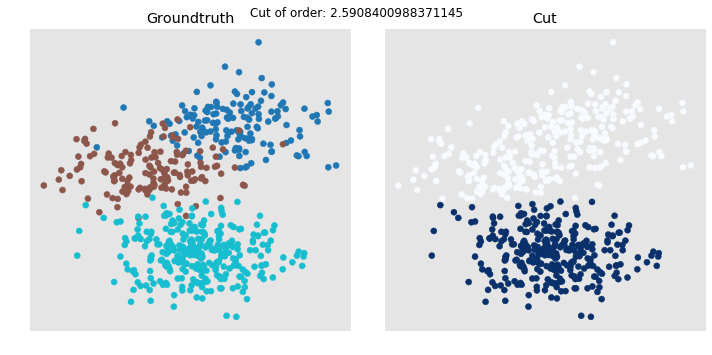

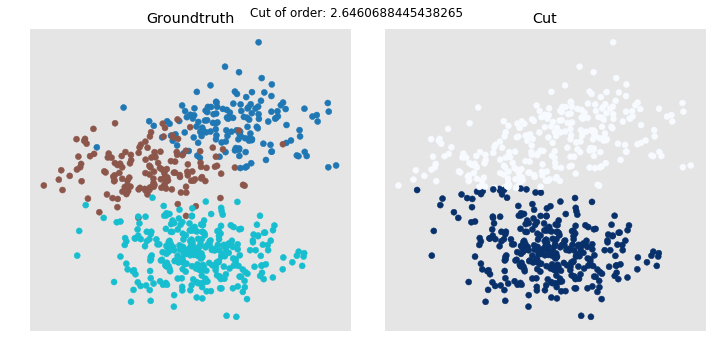

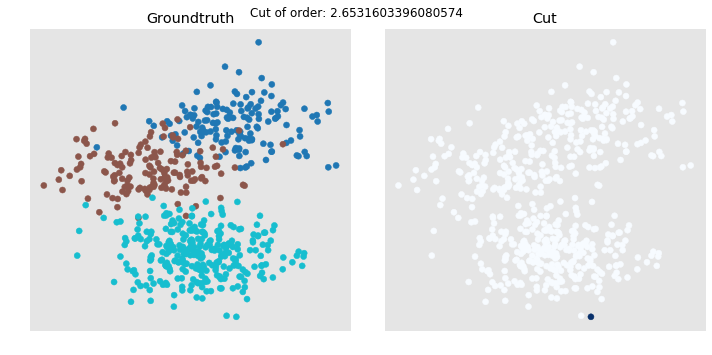

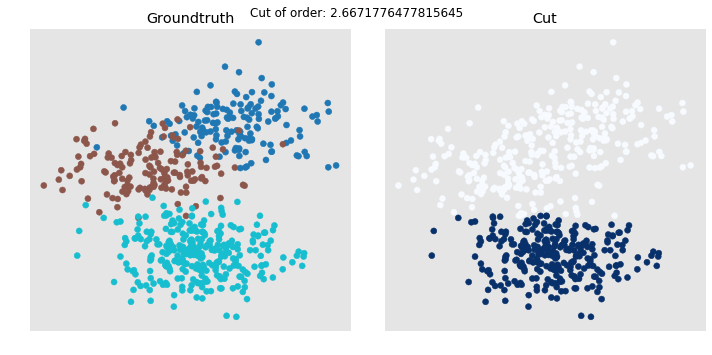

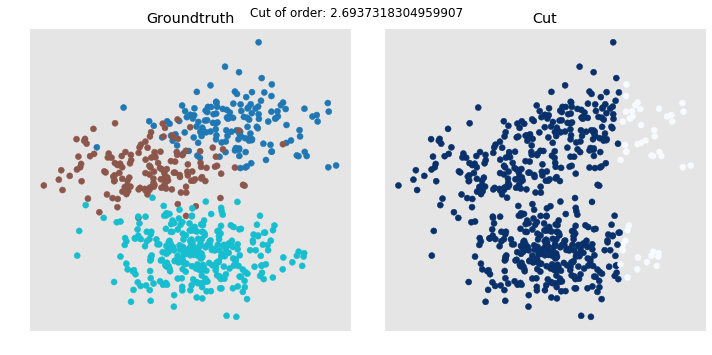

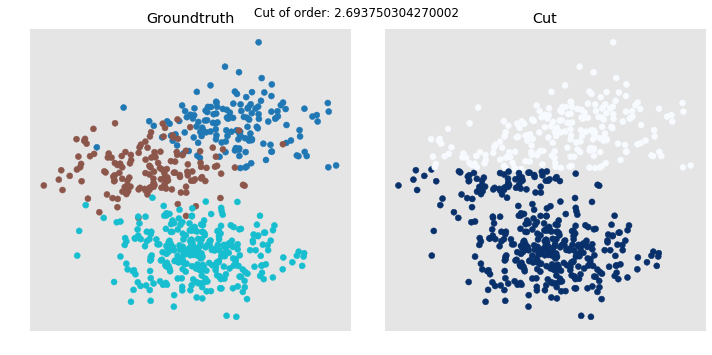

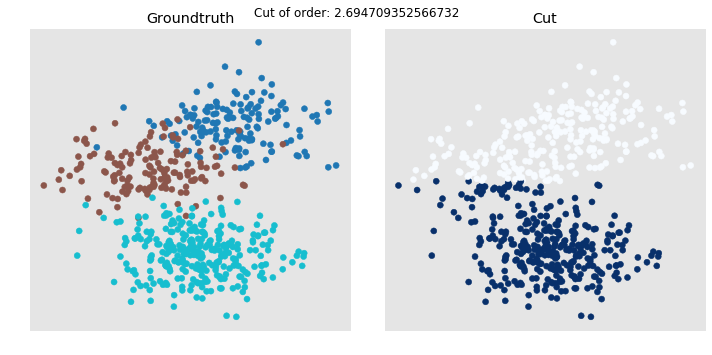

In [259]:
plotting.plot_cuts(data=data, cuts=bipartitions, nb_cuts_to_plot=10, path=None)